In [1]:
import cv2 as cv
import numpy as np
import os
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import matplotlib.patches as patches

import pandas as pd
import scipy as sp

from PIL import Image as im
import napari as nap

# 1. Hough Transform for Circle Detection 
(Do not need to do everytime unless mask has changed for some ungodly reason.)

In [2]:
img = cv.imread(r'/Users/halensolomon/Code/FLFM_local/testing/mask.tif', cv.IMREAD_GRAYSCALE)
min_radius = int(len(img[0,:])/9)

circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1.2, 1.5*min_radius, param1=70,param2=25, minRadius= min_radius,maxRadius=3*min_radius)
circles = np.uint16(np.around(circles))
circles = np.reshape(circles, (circles.shape[1], circles.shape[2]))

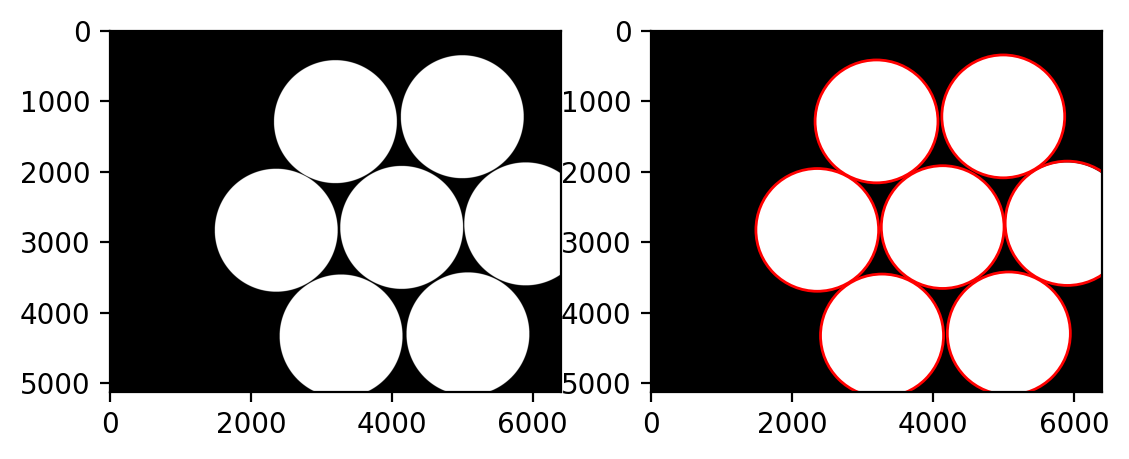

In [3]:
figure = plt.figure()
ax1, ax2 = figure.subplots(1,2)

for i in circles:
    # draw the outer circle
    #plt.imshow(cv.circle(img,(i[0],i[1]),i[2],(255,255,255),2))
    # draw the center of the circle
    circle = patches.Circle((i[0],i[1]),i[2], fill = False, color = 'r')
    ax2.add_patch(circle)
ax2.imshow(img, cmap= 'gray')
ax1.imshow(img, cmap= 'gray')

In [4]:
# Find which one is the center circle
circle_x_avg = np.mean(circles[:,0])
circle_y_avg = np.mean(circles[:,1])
circle_r_avg = np.mean(circles[:,2])

distances = []
theta = []

for i in range(len(circles[:,0])):
    x,y = circles[i,0]-circle_x_avg, circles[i,1]-circle_y_avg
    distances.append(np.sqrt((circles[i,0]-circle_x_avg)**2 + (circles[i,1]-circle_y_avg)**2))
    theta.append(np.arctan2(y,x))

theta = np.delete(theta, np.argmin(distances)) # Remove the center circle
distances = np.delete(distances, np.argmin(distances)) # Remove the center circle

theta = np.sort(theta) # Sort the angles
  
circle_theta_avg = np.mean(theta)
circle_theta_avg2 = (np.argmax(theta) - np.argmin(theta)) / (len(theta) - 1)
circle_dist_avg = np.mean(distances)

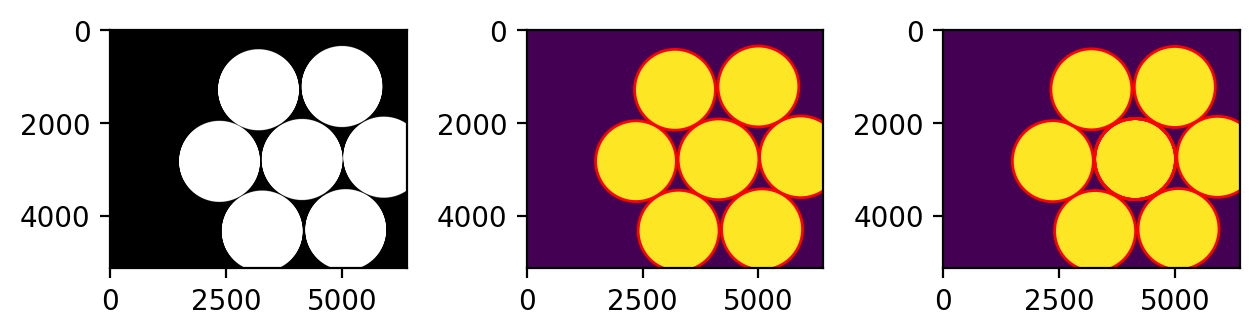

In [5]:
figure2 = plt.figure()
figure2.set_tight_layout(True)
ax1, ax2, ax3 = figure2.subplots(1,3)
ax1.imshow(img, cmap= 'gray')

for i in circles:
    # draw the outer circle
    circle = patches.Circle((i[0],i[1]),i[2], fill = False, color = 'r')
    ax2.add_patch(circle)
    ax2.imshow(img)

for i in range(len(theta)):
    # draw the center circle
    center = patches.Circle((circle_x_avg,circle_y_avg),circle_r_avg, fill = False, color = 'r')
    # Draw the outer circles by multiplying the average angle by i
    circle = patches.Circle((circle_x_avg+circle_dist_avg*np.cos(theta[i]),circle_y_avg+circle_dist_avg*np.sin(theta[i])),circle_r_avg, fill = False, color = 'r') # really good fit
    ax3.add_patch(center)
    ax3.add_patch(circle)
    ax3.imshow(img)

In [6]:
new_circles = np.array([circle_x_avg, circle_y_avg, circle_r_avg])

for i in range(len(theta)):
    new_circles = np.vstack((new_circles, (circle_x_avg+circle_dist_avg*np.cos(theta[i]), circle_y_avg+circle_dist_avg*np.sin(theta[i]), circle_r_avg))) # new circle centers and radii

In [7]:
print(new_circles)

[[4137.28571429 2780.          873.42857143]
 [3194.13383661 1275.64328611  873.42857143]
 [4993.27883978 1224.39710848  873.42857143]
 [5912.16944753 2730.88462118  873.42857143]
 [5073.91732684 4288.42494323  873.42857143]
 [3274.26517933 4331.7152262   873.42857143]
 [2362.29076368 2824.91672634  873.42857143]]


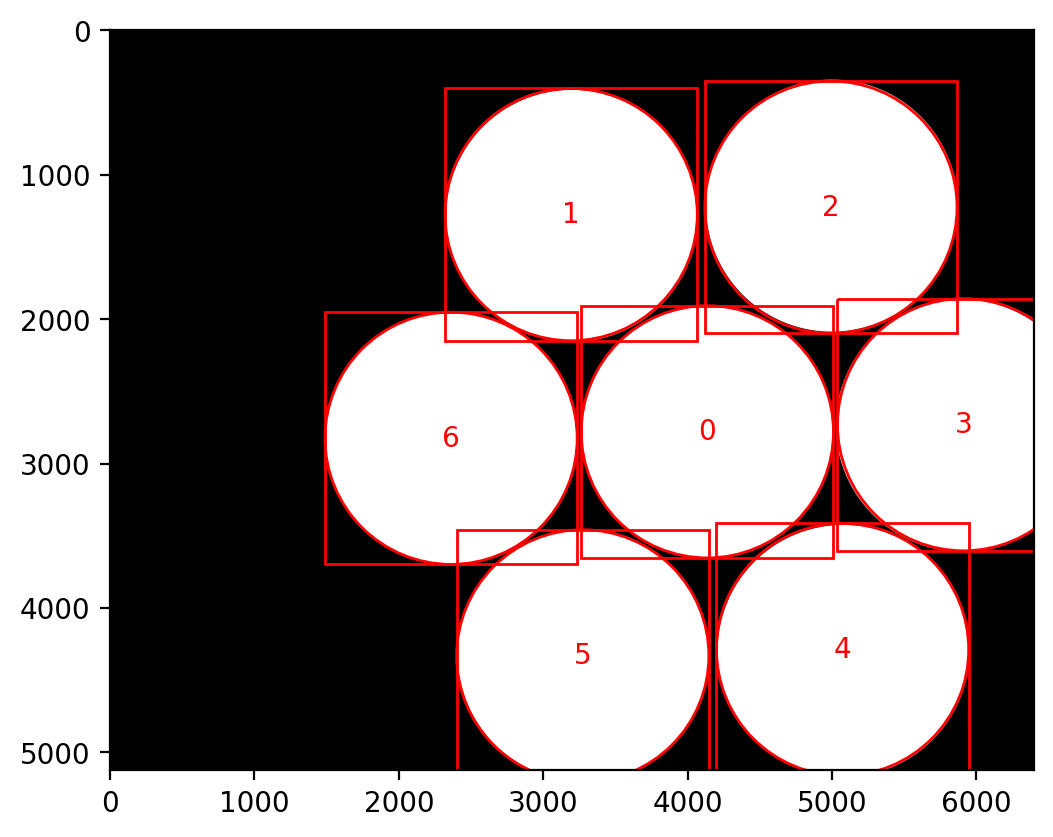

In [8]:
figure3 = plt.figure()
ax1 = figure3.subplots(1,1)

ax1.imshow(img, cmap= 'gray')

for i in range(len(new_circles[:,0])):
    # draw the outer circle
    squares = patches.Rectangle((new_circles[i,0]-new_circles[i,2], new_circles[i,1]-new_circles[i,2]), 2*new_circles[i,2], 2*new_circles[i,2], fill = False, color = 'r')
    circle = patches.Circle((new_circles[i,0],new_circles[i,1]),new_circles[i,2], fill = False, color = 'r')
    ax1.add_patch(squares)
    ax1.add_patch(circle)
    
    # Add the order of the circles in the center of each circle
    ax1.text(new_circles[i,0], new_circles[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')

# Just to test an idea, import two images

In [9]:
image_path = [r'/Users/halensolomon/Code/FLFM_local/testing/02.tif', r'/Users/halensolomon/Code/FLFM_local/testing/03.tif']
frames = []
for i in image_path:
    imge = im.open(i)
    frames.append(np.array(imge).astype(np.int16))
print(frames)

[array([[3, 3, 2, ..., 1, 1, 1],
       [3, 3, 2, ..., 2, 1, 1],
       [2, 2, 0, ..., 1, 2, 2],
       ...,
       [0, 1, 1, ..., 1, 2, 2],
       [1, 1, 0, ..., 2, 2, 2],
       [1, 0, 0, ..., 2, 2, 2]], dtype=int16), array([[3, 3, 2, ..., 1, 1, 1],
       [3, 4, 3, ..., 1, 1, 1],
       [2, 2, 1, ..., 1, 2, 2],
       ...,
       [0, 1, 1, ..., 1, 2, 2],
       [1, 1, 0, ..., 2, 2, 2],
       [1, 0, 0, ..., 2, 2, 2]], dtype=int16)]


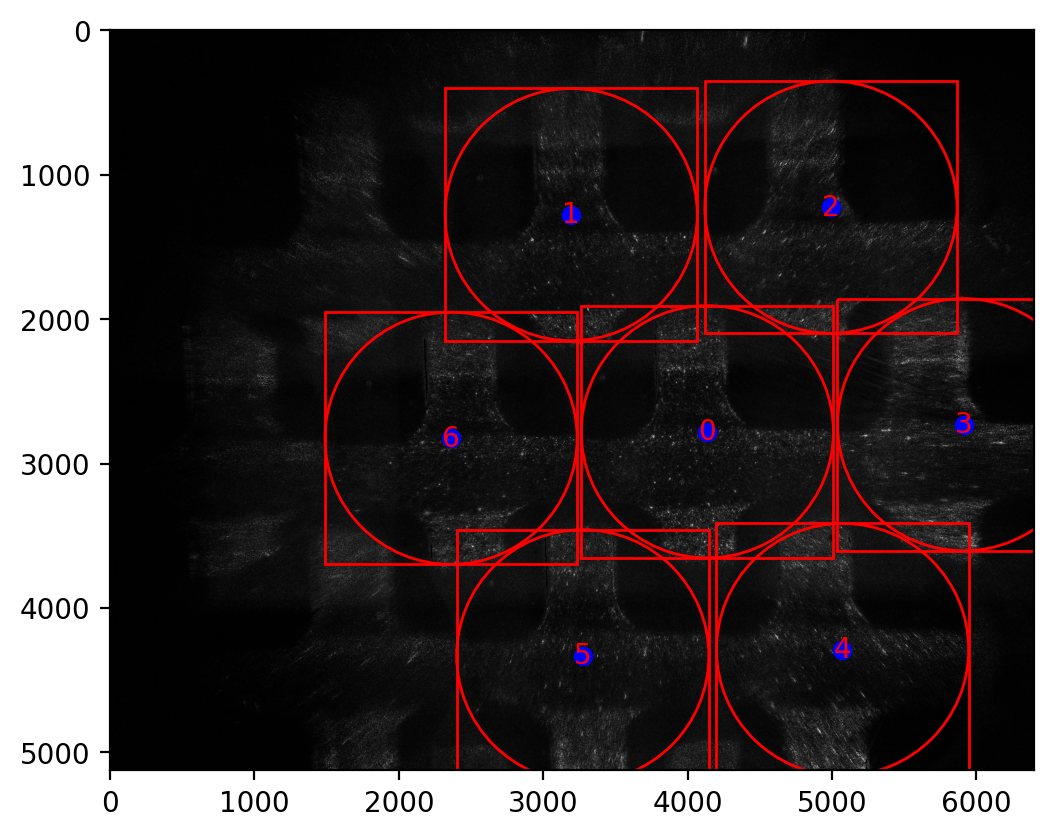

In [10]:
figure4 = plt.figure()
ax1 = figure4.subplots(1,1)

for i in range(len(new_circles[:,0])):
    # draw the outer circle
    squares = patches.Rectangle((new_circles[i,0]-new_circles[i,2], new_circles[i,1]-new_circles[i,2]), 2*new_circles[i,2], 2*new_circles[i,2], fill = False, color = 'r')
    circle = patches.Circle((new_circles[i,0],new_circles[i,1]),new_circles[i,2], fill = False, color = 'r')
    ax1.add_patch(squares)
    ax1.add_patch(circle)
    # Add the order of the circles in the center of each circle
    ax1.text(new_circles[i,0], new_circles[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')
    #plot the centers of the circles
    ax1.scatter(int(new_circles[i,0]), int(new_circles[i,1]), color = 'b')
    
ax1.imshow(frames[0], cmap= 'gray')

In [11]:
# Check if the image is the same size as the calibration image
frames[0][:,:].shape == img.shape

True

In [12]:
new_circles[:,0]

array([4137.28571429, 3194.13383661, 4993.27883978, 5912.16944753,
       5073.91732684, 3274.26517933, 2362.29076368])

In [13]:
len(frames[0][0,:])

6400

In [37]:
lenslet_distances = np.zeros((len(new_circles[:,0]), len(new_circles[:,0])))
lenslet_angles = np.zeros((len(new_circles[:,0]), len(new_circles[:,0])))

for i in range(len(new_circles[:,0])):
    zero_to_i = new_circles[i,0] - new_circles[0,0]
    zero_to_i_1 = new_circles[i,1] - new_circles[0,1]
    


# Find the distances between the lenset centers
for i in range(len(new_circles[:,0])):
    for j in range(len(new_circles[:,0])):
        lenslet_distances[i,j] = (np.sqrt((new_circles[i,0]-new_circles[j,0])**2 + (new_circles[i,1]-new_circles[j,1])**2))
        lenslet_angles[i,j] = np.arctan2(new_circles[i,1]-new_circles[j,1], new_circles[i,0]-new_circles[j,0])

# Grab the 2nd diagonal of the matrix
lenslet_distances = np.diagonal(lenslet_distances, offset = 1)
lenslet_angles = np.diagonal(lenslet_angles, offset = 1)

#lenslet_angle_avg = np.mean(lenslet_angles)
lenslet_distance_avg = np.mean(lenslet_distances)
#print(lenslet_angles)
#print(lenslet_distance_avg, lenslet_angle_avg)

In [22]:
mask_array = np.zeros((int(2*new_circles[0,2]+1),int(2*new_circles[0,2]+1)))

# Create a circular mask that has 0s outside the circle and 1s inside the circle
for i in range(int(2*new_circles[0,2]+1)):
    r = new_circles[0,2]
    for j in range(int(2*new_circles[0,2]+1)):
        
        if np.sqrt((i-r)**2 + (j-r)**2) <= r: # Assuming the radius of the first circle is the same as the rest
            mask_array[i,j] = 1
        else:
            mask_array[i,j] = 0

mask_tensor = torch.from_numpy(mask_array)

In [15]:
perspectives = torch.zeros(int(len(frames)), int(len(new_circles[:,0])) , int(2*new_circles[0,2]+1), int(2*new_circles[0,2]+1)) # Making the different perspectives te "channels", also the frames are always odd numbers

for i in range(len(frames)):
    for j in range(len(new_circles[:,0])):
        placeholder = torch.Tensor(frames[i][int(new_circles[j,1]-new_circles[j,2]):int(new_circles[j,1]+new_circles[j,2]), int(new_circles[j,0]-new_circles[j,2]):int(new_circles[j,0]+new_circles[j,2])]) # Don't know why x and y are switched
        print(int(new_circles[j,0]-new_circles[j,2]), int(new_circles[j,0]+new_circles[j,2]), int(new_circles[j,1]-new_circles[j,2]), int(new_circles[j,1]+new_circles[j,2]))
        
        if placeholder.shape == perspectives[0,0,:,:].shape:
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:]
            
        else:
            # If the circle is too close to the edge of the image, we need to pad it
            placeholder_x_deficit = int(2*new_circles[j,2]+1) - placeholder.shape[0]
            placeholder_y_deficit = int(2*new_circles[j,2]+1) - placeholder.shape[1]
            
            if placeholder_x_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
            if placeholder_x_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
                
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:] # This is the same as the placeholder, but padded with zeros if the circle is too close to the edge of the image

3263 5010 1906 3653
2320 4067 402 2149
4119 5866 350 2097
5038 6785 1857 3604
4200 5947 3414 5161
2400 4147 3458 5205
1488 3235 1951 3698
3263 5010 1906 3653
2320 4067 402 2149
4119 5866 350 2097
5038 6785 1857 3604
4200 5947 3414 5161
2400 4147 3458 5205
1488 3235 1951 3698


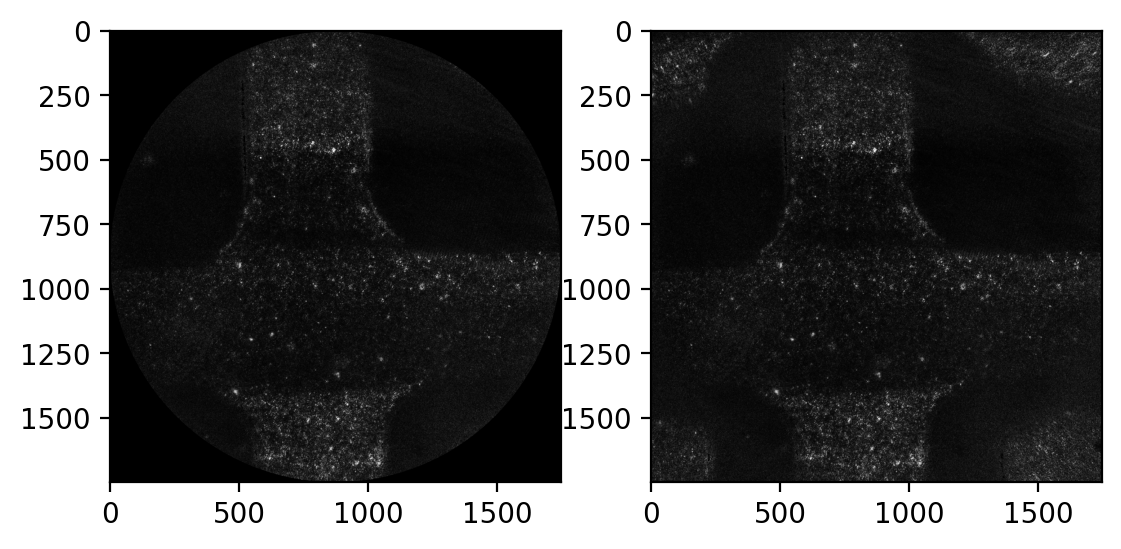

In [16]:
# Plotting the different perspectives
figure4 = plt.figure()
ax1,ax2 = figure4.subplots(1,2)

ith= int(1)
jth= int(0)

ax1.imshow(perspectives[ith,jth,:,:], cmap= 'gray')
ax2.imshow(frames[ith][int(new_circles[jth,1]-new_circles[jth,2]):int(new_circles[jth,1]+new_circles[jth,2]), int(new_circles[jth,0]-new_circles[jth,2]):int(new_circles[jth,0]+new_circles[jth,2])], cmap= 'gray')

# Frames locked and loaded, time to fuck shit up

### 4.2 Projection operators in FLFM

Function

_Projection = FLFM_forwardProject(H, realSpace)_

implements the light field forward projection operator. It applies the pre-computed (see Sec. 3.2) forward light model, H to a given 3D volume, realSpace and returns a light field image, "Projection".

In order to project the object, realSpace using the LFPSF in H, we perform 2D slice-by-slice convolutions at every depth and cumulate the responses:

_Projection = Projection + conv2(realSpace(:,:,j), full(H(1,1,j)),’same’)_ .

Function 

_BackProjection = FLFM_backwardProject(Ht, projection)_

implements the light field backward projection operator. It applies the pre-computed (see Sec. 3.2) backward patterns, Ht to a given light field image, projection and returns a 3D volume, BackProjection. In order to apply the patterns in Ht to the light field image, projection, the LFM_backwardProject function implements slice-by-slice convolutions in an analogous manner to the FLFM_forwardProject function described above:

_BackProjection(:,:,j) = conv2(projection , full(Ht(1,1,j)),’same’)_.

For details on the implementation of the projection operators, see the corresponding Matlab files.

We first propagate
the field to the native object plane (NOP; see Fig. 7), and then function [U1, LU1] =
FLFM_lensProp(U0, LU0, Camera.WaveLength, Camera.fobj) implements the Fourier
property of a lens (under paraxial context) to generate the field at the back focal plane
(see AS plane in Fig. 7) of the objective as a scaled Fourier transform of the field at the
front focal plane. The field at the MLA plane is then just a scaled version of the field
at the AS plane, by the relay magnification factor, Mrelay = Camera.f2/Camera.f1.
For implementation details of these functions, see the corresponding Matlab functions
(Sec. 5).

### Grabbed from FLFMconfigGW.yml

- gridType: 'hex'
- NA: 0.4
- fobj: 10000
- f1: 1
- f2: 1
- fm: 47000
- mla2sensor: 47000
- lensPitch: 2520
- pixelPitch: 3.54
- WaveLength: 0.5530
- n: 1
- noLensHoriz: 3
- noLensVert: 3
- shiftRow: 1
- spacingPixels: 777  
- horizOffset: 1269
- vertOffset: 690
- gridRot: 0

In [17]:
# Set-up Specific Constants

grid_Type = "hex"

NA = 0.4
fobj = 10000
f1 = 1
f2 = 1
fm = 47000

mla2sensor = 47000
lenspitch = 2520
pixel_pitch = 3.54
wavelength = 0.5530
refractive_index = 1

noLensHoriz = 3
noLensVert = 3

spacingPixels = 777
horizOffset = 1269
vertOffset = 690

shiftRow = 0
gridRot = 0

### Grabbed from FLFM_setCameraParam_PDH.m

function [Camera, LensletGridModel] = FLFM_setCameraParams_PDH(configFile, superResFactor)

%% set FLFM parameters:
%%%% microscope params
% fobj-> objective magnification
% NA-> objective aperture
% f1 -> relay lens 1
% f2 -> relay lens 2

%%%% sensor
% lensPitch-> lenslet pitch
% pixelPitch-> sensor pixel pitch

%%%% MLA params
% gridType-> microlens grid type: "reg" -> regular grid array; "hex" -> hexagonal grid array 
% fm-> focal length of the lenslets

%%%% light characteristics
% n-> refraction index (1 for air)
% wavelenght-> wavelenght of the the emission light

%%%% distances
% mla2sensor-> distance between MLA and sensor

%%% MLA array descriptor 
% spacingPixels-> number of pixels between horizontal neighboring elemental (sub-aperture) images
% noLensHoriz-> number of elemental images horizontally 
% noLensVert-> number of elemental images vertically
% shiftRow-> '1' or '2' when odd or even rows are shifted, respectively (in hex grid only)

Camera = ReadYaml(configFile);
Camera.spacingPixels = Camera.spacingPixels * superResFactor;
Camera.superResFactor = superResFactor;

Camera.objRad = Camera.fobj * Camera.NA; % objective radius
Camera.k = 2*pi*Camera.n/Camera.WaveLength; % wave number
Camera.M = Camera.fm*Camera.f1/(Camera.f2*Camera.fobj); %total system magnification

% index of refract step

Camera.d = 3.5e-3;

% field stop radius 
Camera.fsRad = Camera.lensPitch/2 * Camera.f2/Camera.fm;

% field of view radius
Camera.fovRad =  Camera.fsRad * Camera.fobj/Camera.f1;

%%%% MLA array descriptor
LensletGridModel.gridType = Camera.gridType;
LensletGridModel.UMax = Camera.noLensHoriz;
LensletGridModel.VMax = Camera.noLensVert;
LensletGridModel.FirstPosShiftRow = Camera.shiftRow; % in hexagonal grids 
LensletGridModel.Orientation = 'horz';

LensletGridModel.HSpacing = Camera.spacingPixels;
LensletGridModel.HSpacing = LensletGridModel.HSpacing + mod(LensletGridModel.HSpacing,2); % make sure it is even

if(strcmp(Camera.gridType, 'hex'))
    LensletGridModel.VSpacing = round(sqrt(3)/2*LensletGridModel.HSpacing);
    LensletGridModel.VSpacing = LensletGridModel.VSpacing + mod(LensletGridModel.VSpacing,2); % make sure it is even
else
    LensletGridModel.VSpacing = LensletGridModel.HSpacing;
end
LensletGridModel.HOffset = Camera.horizOffset * superResFactor;
LensletGridModel.VOffset = Camera.vertOffset * superResFactor;
LensletGridModel.Rot = Camera.gridRot;

In [19]:
def FLFM_setCameraParams(config):
    # Config should be an array with the following parameters:
    # [NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_pitch, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot]
    
    objRad = config[0] * config[1] # Objective radius = NA * fobj
    k = 2 * np.pi * config[9] / config[8] # k = 2 * pi * refractive_index / wavelength (wave number)
    M = (config[4] * config[3]) / (config[2] * config[1])
    d_refract = 3.5e-3 # Index of Refraction (__Don't know wherer the number came from__)
    fsRad = config[6] * config[3] / (2 * config[4]) # Field stop radius = lenspitch * f2 / (2 * fm)
    fovRad = fsRad / config[2]
    return [objRad, k, M, d_refract, fsRad, fovRad]

# it might not be necessary to port the lenslet grid descriptor to python    

function psfSTACK = FLFM_calcPSFAllDepths_PDH(Camera, Resolution)
    % Computes PSF for all Resolution.depths, exploiting the symetry of Resolution.depths at the same absolute distance to the zero plane

psfSTACK = zeros(length(Resolution.yspace), length(Resolution.xspace), length(Resolution.depths));
for i = 1:length(Resolution.depths)
    computePsf = 1;
    
    % Check if the abs(depth) was previoulsy computed, as zero-symetric depths are just conjugates.
    idx = find(abs(Resolution.depths(1:i-1)) == abs(Resolution.depths(i)));
    if ~isempty(idx)
        computePsf = 0;
    end
    
    % If depth has not been computed, compute it
    if computePsf == 1
        % the psf is translationally invariant, so it is sufficient to compute in the origin
        d=3.5e-3;Camera.d;
        psfWAVE = FLFM_calcPSF_PDH(0, 0,  Resolution.depths(i), d , 1.33, Camera, Resolution);
    else
        % if it is exactly the same depth just copy it
        if Resolution.depths(i) == Resolution.depths(idx)
            psfWAVE = psfSTACK(:,:,idx);
        else
            % if it is the negative, conjugate
            psfWAVE = conj(psfSTACK(:,:,idx));
        end
    end
    psfSTACK(:,:,i)  = psfWAVE; 
end
end

% oLaF - a flexible 3D reconstruction framework for light field microscopy
% Copyright (c)2017-2020 Anca Stefanoiu 

function [LensletCenters, Resolution] = FLFM_computeGeometryParameters(CaibrationImage, Camera, LensletGridModel, depthRange, depthStep)

%% Compute resolution according to the new grid
Resolution = FLFM_computeResolution(LensletGridModel, Camera, depthRange, depthStep);
disp(['Super resolution factor of: ', num2str(Resolution.superResFactor),' Pix size: [', num2str(Resolution.sensorRes(1)),', ',num2str(Resolution.sensorRes(2)),...
        '] Vox size: [', num2str(Resolution.texRes(1)), ', ',num2str(Resolution.texRes(2)),', ',num2str(Resolution.texRes(3)),']']);
    
%% Compute lenslets centers on the sensor and corresponding repetition patches centers in texture space (in voxels)
% LensletCenters = FLFM_computeLensCenters(CaibrationImage, Camera, LensletGridModel); 
%SW Introduction

LensletCenters = [];
%Resolution.LensletCenters = LensletCenters;

% sensor size in pixels
Resolution.sensorSize = size(CaibrationImage);

% oLaF - a flexible 3D reconstruction framework for light field microscopy
% Copyright (c)2017-2020 Anca Stefanoiu 

function [Camera, LensletGridModel] = FLFM_setCameraParams(configFile, superResFactor)

%% set FLFM parameters:
%%%% microscope params
% fobj-> objective magnification
% NA-> objective aperture
% f1 -> relay lens 1
% f2 -> relay lens 2

%%%% sensor
% lensPitch-> lenslet pitch
% pixelPitch-> sensor pixel pitch

%%%% MLA params
% gridType-> microlens grid type: "reg" -> regular grid array; "hex" -> hexagonal grid array 
% fm-> focal length of the lenslets

%%%% light characteristics
% n-> refraction index (1 for air)
% wavelenght-> wavelenght of the the emission light

%%%% distances
% mla2sensor-> distance between MLA and sensor

%%% MLA array descriptor 
% spacingPixels-> number of pixels between horizontal neighboring elemental (sub-aperture) images
% noLensHoriz-> number of elemental images horizontally 
% noLensVert-> number of elemental images vertically
% shiftRow-> '1' or '2' when odd or even rows are shifted, respectively (in hex grid only)

Camera = ReadYaml(configFile);
Camera.spacingPixels = Camera.spacingPixels * superResFactor;
Camera.superResFactor = superResFactor;

Camera.objRad = Camera.fobj * Camera.NA; % objective radius
Camera.k = 2*pi*Camera.n/Camera.WaveLength; % wave number
Camera.M = Camera.fm/Camera.fobj; %total system magnification

% field stop radius 
Camera.fsRad = (Camera.lensPitch/2) * (Camera.fobj/Camera.fm);

% field of view radius
Camera.fovRad =  Camera.fsRad;

%%%% MLA array descriptor
LensletGridModel.gridType = Camera.gridType;
LensletGridModel.UMax = Camera.noLensHoriz;
LensletGridModel.VMax = Camera.noLensVert;
LensletGridModel.FirstPosShiftRow = Camera.shiftRow; % in hexagonal grids 
LensletGridModel.Orientation = 'horz';

LensletGridModel.HSpacing = Camera.spacingPixels;
LensletGridModel.HSpacing = LensletGridModel.HSpacing + mod(LensletGridModel.HSpacing,2); % make sure it is even

if(strcmp(Camera.gridType, 'hex'))
    LensletGridModel.VSpacing = round(sqrt(3)/2*LensletGridModel.HSpacing);
    LensletGridModel.VSpacing = LensletGridModel.VSpacing + mod(LensletGridModel.VSpacing,2); % make sure it is even
else
    LensletGridModel.VSpacing = LensletGridModel.HSpacing;
end
LensletGridModel.HOffset = Camera.horizOffset * superResFactor;
LensletGridModel.VOffset = Camera.vertOffset * superResFactor;
LensletGridModel.Rot = Camera.gridRot;

In [ ]:
def resolution(config, depth_rage, depth_step):
    

% oLaF - a flexible 3D reconstruction framework for light field microscopy
% Copyright (c)2017-2020 Anca Stefanoiu 

% Adapted after Felix Wechsler's 'Wavefront Coding Techniques for Extended Depth of Field in Light Field Microscopy' BA thesis
% felix.wechsler@tum.de

% edited for spherical aberations due to step in optical index , PDH 2022

function [psf] = FLFM_calcPSF_PDH(p1, p2, p3, d, n2, Camera, Resolution)
% fobj -> MO's focal length
% NA -> MO's numerical aperture
% yspace, xspace -> sensor space coordinates
% d -> distance from nominal focal plane to interface
% n -> immersion media
% n2 -> step index of refraction

n = Camera.n; % refractive index
kn = 2*pi/Camera.WaveLength*n; % wave number
%% phase delay suffered by the rays is the optical path difference
if n~=n2
NA=Camera.NA;
theta=asin(NA);
W = d./Camera.WaveLength.*(n-n2)*(1+2*n/n2*sin(theta/2)^2+2*(n+n2)*n^2/n2^3*sin(theta/2)^4);
else
W=0;
end
%% Wavefront at the MO's fron focal plane
A = 1; % some amplitude

% choose unevent number of points to have a mid point
N = 4095; % samples -> relatively large to make sure the field is not undersampled
midPoint = (N + 1) / 2;
NoutputY = length(Resolution.yspace);
NoutputX = length(Resolution.xspace);

% physical length of the sampled input field at the NOP in micrometers
LU0 = 500;

% coordinates of the NOP 
x = linspace(-LU0/2, LU0/2, N);
y = x;
[X,Y] = meshgrid(x,y);

% if the source point is at the front focal plane (NOP) => a delta peak
if p3 == 0
    p3 = 1e-8;
end

% distance from point source to the MO
r = sqrt((X-p1).^2.+(Y-p2).^2.+p3.^2)./n;

% when p3>0, propagate back to the lens 
if p3 > 0
    r = -1*r;
end
% field at the NOP
U0 = -1i*A*kn/2/pi./r .* exp(1i.*kn.*r);

%% Wavefront at the MO's front focal plane
% due to the FFT there is a scaling factor and LU1 is the length of the field at the the back aperture stop of the MO
[U1, LU1] = FLFM_lensProp(U0, LU0, Camera.WaveLength, Camera.fobj);
coeffU1minus = -1i*exp(1i*kn*Camera.fobj)/Camera.WaveLength/Camera.fobj;
U1 = coeffU1minus.*U1;

% back aperture stop
circ = @(x,y,r) (x.^2.+y.^2.<r.^2); % pupil function
dobj = 2*Camera.fobj*Camera.NA;
U1 = U1.*circ(X./LU0.*LU1, Y./LU0.*LU1, dobj./2);;

%% Relay magnification effect (when Camera.f1 != Camera.f2)
Mrelay = Camera.f2/Camera.f1;

% we have to reshape U1 to match the spacing and extent of the xspace and yspace
cut = [round(Resolution.yspace(end) / (Mrelay*LU1/2) * (N+1)/2), round(Resolution.xspace(end) / (Mrelay*LU1/2) * (N+1)/2)];
psf = U1(midPoint - cut(1) : midPoint + cut(1), midPoint - cut(2) : midPoint + cut(2));

% downsample the psf the back focal plane of the MO
psf = imresize(psf, [NoutputY NoutputX], 'bicubic');


In [ ]:
def psfCalc(config, fobj, k, NA, x_sensor, y_sensor, d, n, n_step):
    # fobj = objective focal length
    # k = wave number
    # NA = objective numerical aperture
    # x_sensor = x coordinate of the sensor
    # y_sensor = y coordinate of the sensor
    # d = lenslet pitch
    # n = refractive index
    # n_step = number of steps in the z direction
    
    # phase delay suffered by the rays is the optical path difference
    if n != n_step:
        theta_half = theta / 2
        diff = (d / config[8]) * (n-n_step) * (1 + 2*n / n_step * np.sin(theta_half)^2 + 2*(n+n_step) * (n**2) / (n_step**3) * np.sin(theta_half)^4)
    else:
        diff = 0
        
    # Now we simulate the propagation of the rays to the sensor plane
    amp = 1 # Normalized amplitude of the rays
    N = 9999 # discritization of the plane
    mid = int((N+1)/2) # Where the delta function is located
    
    
    

In [21]:
# These are user defined parameters (Thanks Steve)

depth_step = 10 # The relative depth of the z-stack

depthRange = [-100, 100]; # reconstruction depth range (im um) (for 2D objects depthRange start and end are the same)
depthStep = 10; # axial resolution (in um); dummy value for 2D objects

Iterations = 10; # Number of RL iterations

superResFactor = 1; # Super-resolution factor (1 = no super-resolution)


# lensletRadius = 370; %Radius in pixels of a single lenslet in the raw image (It should already be detected and known through Hough Transform)
# DesiredFOV = 350; # FOV(pixels) Chosen over each Lenslet (Will come back to this later)
# useCalibrationimage = false; #If there is not a sufficient background Calibration Image for finding Lenslet centers, set to False

# Forward and Backward projection

# Finding H and its transpose